In [ ]:
# CUDA: Let's check that Nvidia CUDA drivers are already pre-installed and which version is it.
!/usr/local/cuda/bin/nvcc --version
# We need to install the correct cuDNN according to this output

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
!nvidia-smi

Thu Sep 22 01:40:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Change the number depending on what GPU is listed above, under NVIDIA-SMI > Name.
# Tesla K80: 30
# Tesla P100: 60
# Tesla T4: 75v
%env compute_capability=70

env: compute_capability=70


In [ ]:
%cd ..
from google.colab import drive
#drive.flush_and_unmount()

drive.mount('/content/drive')

/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 

import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance

from tensorflow import keras


from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,plot_roc_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
%cd '/content/drive/My Drive/Interview/Credit Sesame/'
%ls

/content/drive/My Drive/Interview/Credit Sesame
'Data Scientist Take Home.pdf'        'default of credit card clients.xlsx'
'default of credit card clients.xls'  'Take Home Assessment.ipynb'


In [ ]:
data=pd.read_excel('default of credit card clients.xlsx',header=1,index_col='ID')
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
data.shape

(30000, 24)

In [ ]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

## A) Data Cleaning

#### Typo in header

In [ ]:
data = data.rename(columns={'PAY_0': 'PAY_1'})

In [ ]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

#### Check missing data

In [ ]:
data.isnull().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_1                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

#### Check data type

In [ ]:
data.dtypes

LIMIT_BAL                     int64
SEX                           int64
EDUCATION                     int64
MARRIAGE                      int64
AGE                           int64
PAY_1                         int64
PAY_2                         int64
PAY_3                         int64
PAY_4                         int64
PAY_5                         int64
PAY_6                         int64
BILL_AMT1                     int64
BILL_AMT2                     int64
BILL_AMT3                     int64
BILL_AMT4                     int64
BILL_AMT5                     int64
BILL_AMT6                     int64
PAY_AMT1                      int64
PAY_AMT2                      int64
PAY_AMT3                      int64
PAY_AMT4                      int64
PAY_AMT5                      int64
PAY_AMT6                      int64
default payment next month    int64
dtype: object

#### Check data typo / consistency

In [ ]:
categorical_features = [
    'SEX',
    'EDUCATION',
    'MARRIAGE',
    'PAY_1',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    'default payment next month'
]

In [ ]:
data[categorical_features].describe()

,SEX,EDUCATION,MARRIAGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,1.603733,1.853133,1.551867,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,0.221200
std,0.489129,0.790349,0.521970,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,0.415062
min,1.000000,0.000000,0.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,0.000000
25%,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,6.000000,3.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,1.000000


1) According to the description of the data set, marriage should start with 1 not 0, so there are typos for all the marriage = 0. In that case, we categorize these rows as "Others" since we do not know the true value.

2) Education should start at 1 not 0 and there is no category as "5,6". That's why we regroup those entries = 0,5,6 into 4 "Others". 

3) PAY columns should start -1 but not -2. 


In [ ]:
# Fixing marriage
data['MARRIAGE'] = data['MARRIAGE'].apply(lambda x: 3 if x == 0 else x)

# Fixing education
data['EDUCATION'] = data['EDUCATION'].apply(lambda x: 4 if x in [0, 5, 6] else x)

In [ ]:
# Fixing PAY Columns with value -2

data[data['PAY_1']==-2]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
10,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0
24,450000,2,1,1,40,-2,-2,-2,-2,-2,...,560,0,0,19428,1473,560,0,0,1128,1
34,500000,2,2,1,54,-2,-2,-2,-2,-2,...,7521,71439,8981,4152,22827,7521,71439,981,51582,0
35,500000,1,1,1,58,-2,-2,-2,-2,-2,...,3180,0,5293,5006,31178,3180,0,5293,768,0
46,210000,1,1,2,29,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29947,230000,1,1,2,44,-2,-1,-1,-1,-1,...,1467,9192,4388,3306,806,1500,9216,4388,0,0
29962,260000,1,1,2,33,-2,-2,-2,-2,-2,...,1368,101,955,263,0,1368,101,955,0,0
29980,180000,1,1,1,32,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
len(data[data['PAY_1']==-2])/len(data)

0.09196666666666667

Since there is no information about -1 value for columns "PAY" and it is less than 10% of the dataset, we can consider drop them. 

In [ ]:

numerical_features = [
    'LIMIT_BAL', 
    'AGE', 
    'BILL_AMT1', 
    'BILL_AMT2', 
    'BILL_AMT3', 
    'BILL_AMT4', 
    'BILL_AMT5', 
    'BILL_AMT6', 
    'PAY_AMT1', 
    'PAY_AMT2', 
    'PAY_AMT3', 
    'PAY_AMT4', 
    'PAY_AMT5', 
    'PAY_AMT6'
]


In [ ]:
data[numerical_features].describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


## 2) Data Exploration

### I) Target value

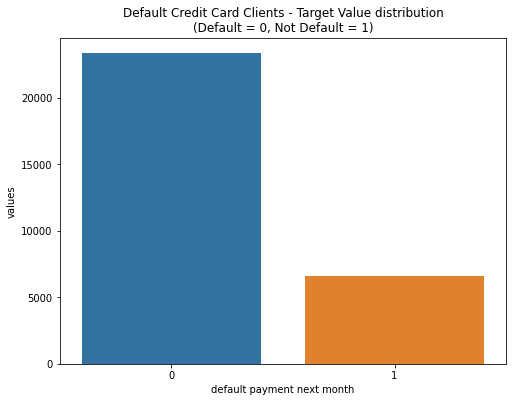

In [ ]:
plt.figure(figsize = (8,6))
target_count = data["default payment next month"].value_counts()
target_count = pd.DataFrame({'default payment next month': target_count.index,'values': target_count.values})
plt.title('Default Credit Card Clients - Target Value distribution\n(Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default payment next month', y="values", data=target_count)
locs, labels = plt.xticks()
plt.show()

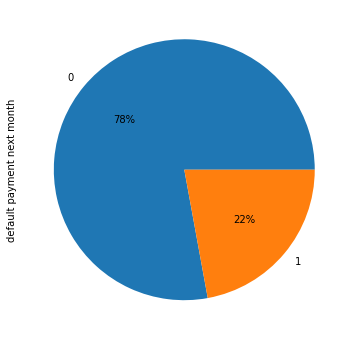

In [ ]:
plt.figure(figsize = (8,6))
pd.value_counts(data['default payment next month']).plot(kind='pie', y='default.payment.next.month', autopct='%1.0f%%');

In [ ]:
target_count['count in %']=target_count['values']/len(data)*100
target_count

,default payment next month,values,count in %
0,0,23364,77.88
1,1,6636,22.12


Majority of the target class is 0 and only 22% of the data is 1. In this case, this is an unbalanced dataset. In data preparation / preprocessing part, we will need to resample them to make it more balanced. 

### II) Credit limit 

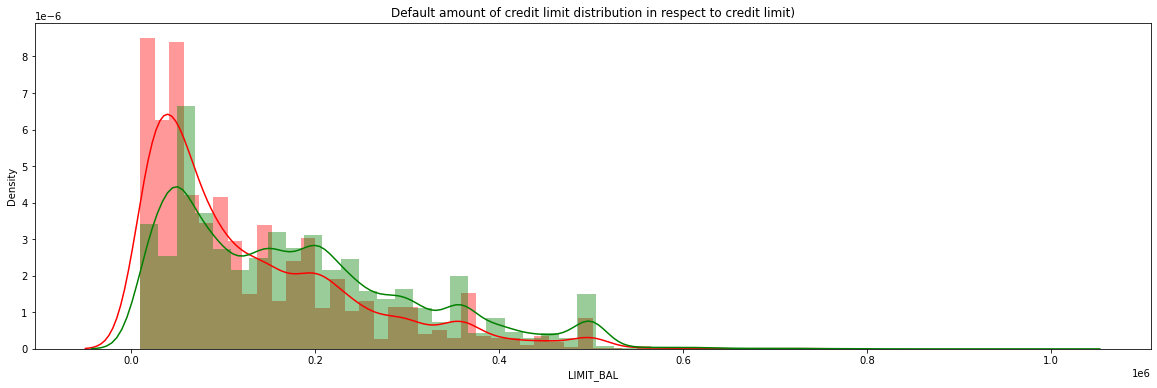

In [ ]:
class_0=data[data['default payment next month']==0]['LIMIT_BAL']
class_1=data[data['default payment next month']==1]['LIMIT_BAL']

plt.figure(figsize = (20,6))
plt.title('Default amount of credit limit distribution in respect to credit limit)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True, color="red")
sns.distplot(class_0,kde=True,color="green")
plt.show()

In [ ]:
class_0.describe()

count      23364.000000
mean      178099.726074
std       131628.359660
min        10000.000000
25%        70000.000000
50%       150000.000000
75%       250000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

In [ ]:
class_1.describe()

count      6636.000000
mean     130109.656420
std      115378.540571
min       10000.000000
25%       50000.000000
50%       90000.000000
75%      200000.000000
max      740000.000000
Name: LIMIT_BAL, dtype: float64

### III) Sex vs Default

Gender (1 = male; 2 = female)

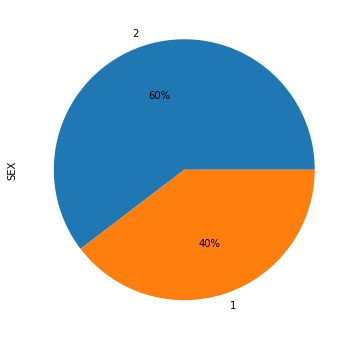

In [ ]:
plt.figure(figsize = (8,6))
pd.value_counts(data['SEX']).plot(kind='pie', y='SEX', autopct='%1.0f%%')

<Figure size 576x432 with 0 Axes>

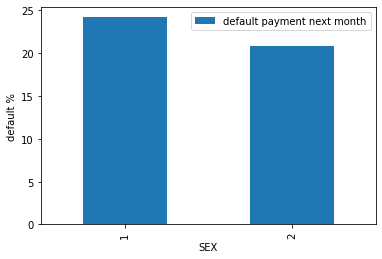

In [ ]:
plt.figure(figsize = (8,6))
val_counts = data.groupby('SEX')['default payment next month'].apply(lambda group: group.value_counts()/len(group)*100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')
plt.show()


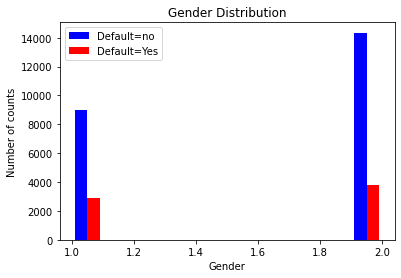

In [ ]:
default_no=data[data['default payment next month']==0]['SEX']
default_yes=data[data['default payment next month']==1]['SEX']

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Number of counts')

plt.hist([default_no,default_yes], color=['blue','red'], label=['Default=no','Default=Yes'])
plt.legend()
plt.show()

### IV) Education

Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

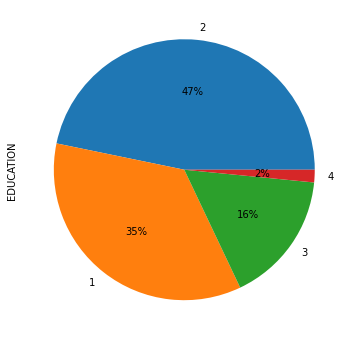

In [ ]:
plt.figure(figsize = (8,6))
pd.value_counts(data['EDUCATION']).plot(kind='pie',y='EDUCATION', autopct='%1.0f%%')

<Figure size 576x432 with 0 Axes>

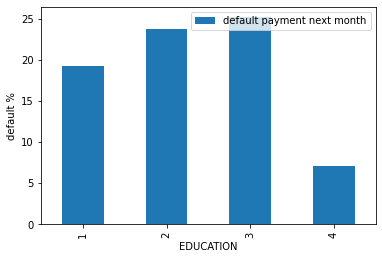

In [ ]:
plt.figure(figsize = (8,6))
val_counts = data.groupby('EDUCATION')['default payment next month'].apply(lambda group: group.value_counts() / len(group) * 100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')

plt.show()

## V) AGE

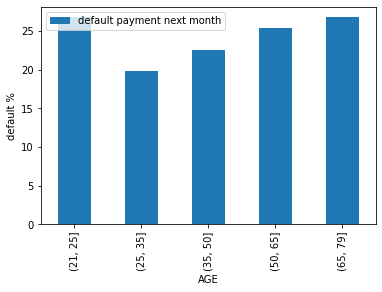

In [ ]:
bin_data=data.copy()
age_bins = [data['AGE'].min(), 25,35,50,65,data['AGE'].max()]
bin_data['AGE']=pd.cut(data['AGE'], age_bins)

val_counts = bin_data.groupby('AGE')['default payment next month'].apply(lambda group: group.value_counts()/ len(group)*100)

val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')

plt.show()


### VI) Payment 

### Frequency

#### Number of paid on time Vs Default rate

Add a column into dataset called "Number_of_paid_on_time"

In [ ]:
# Number of paid on time per individual
pay_cols = ['PAY_{}'.format(x) for x in range(1,7)]
pay_cols = data[pay_cols]
for PAY_col in pay_cols:
  pay_cols[PAY_col]=pay_cols[PAY_col].apply(lambda x:1 if x in [-2,-1,0] else 0)
data['Number_of_paid_on_time']=pay_cols.sum(axis=1)
numerical_features.append('Number_of_paid_on_time')

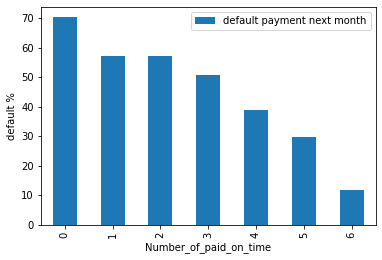

In [ ]:
val_counts = data.groupby('Number_of_paid_on_time')['default payment next month'].apply(lambda group: group.value_counts() / len(group) * 100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')

#### Number of times the payment has been delayed - Frequency

Add a column for number of time payment delayed

In [ ]:
# Number of time the payment has been delayed per individual
pay_cols = ['PAY_{}'.format(x) for x in range(1,7)]
pay_cols = data[pay_cols]
for PAY_col in pay_cols:
  pay_cols[PAY_col]=pay_cols[PAY_col].apply(lambda x:1 if x not in [-2,-1,0] else 0)
data['Number_of_times_delayed']=pay_cols.sum(axis=1)
numerical_features.append('Number_of_times_delayed')

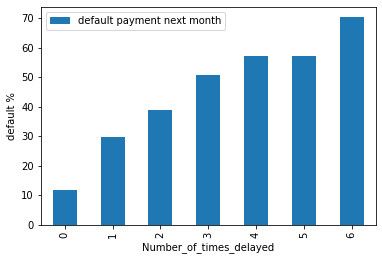

In [ ]:
val_counts = data.groupby('Number_of_times_delayed')['default payment next month'].apply(lambda group: group.value_counts() / len(group) * 100)
val_counts[val_counts.index \
           .get_level_values(1) == 1] \
           .reset_index(level=1) \
           .drop(columns='level_1') \
           .plot(kind='bar', ylabel='default %')

### Recency

#### Most recent delayed payment

Add a column for the recency 

In [ ]:
pay_cols = ['PAY_{}'.format(x) for x in range(6, 1, -1)]
pay_cols = data[pay_cols]
most_recent_index=[]

for i in range(len(pay_cols)):
  recent_index=np.argwhere(pay_cols.iloc[i,:].values >0)

  if  recent_index.size==0:
    most_recent_index.append(0)
  else:
    most_recent_index.append(recent_index.min()+1)
  


In [ ]:
data['most_recent_month_delayed']=most_recent_index
numerical_features.append('most_recent_month_delayed')

### Monetary 

Add a column for outstanding balance (bill - amount paid) accumlatively for last 6 months

In [ ]:
bill_cols = ['BILL_AMT{}'.format(x) for x in range(1,7)]
pay_amount_cols = ['PAY_AMT{}'.format(x) for x in range(1,7)]

outstandings_data = data[bill_cols+pay_amount_cols]

outstandings_amount_list=[]
for i in range(1,len(outstandings_data)+1):
  # print(i)
  total_amount=0
  for ix,(b, p) in enumerate(zip(bill_cols,pay_amount_cols)):
      # print(b,p)
      amount=outstandings_data[str(b)][i]-outstandings_data[str(p)][i]
      total_amount+=amount
  outstandings_amount_list.append(total_amount)

data['Outstanding_total_amount']=outstandings_amount_list

  

numerical_features.append('Outstanding_total_amount')

In [ ]:
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,Number_of_paid_on_time,Number_of_times_delayed,most_recent_month_delayed,Outstanding_total_amount
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,1,4,2,5,7015
2,120000,2,2,2,26,-1,2,0,0,0,...,1000,1000,1000,0,2000,1,4,2,1,12077
3,90000,2,2,2,34,0,0,0,0,0,...,1500,1000,1000,1000,5000,0,6,0,0,90635
4,50000,2,2,1,37,0,0,0,0,0,...,2019,1200,1100,1069,1000,0,6,0,0,222946
5,50000,1,2,1,57,-1,0,-1,0,0,...,36681,10000,9000,689,679,0,6,0,0,50290


## C) Data Preprocessing / Preparation

### I) Set target value , features values


In [ ]:
y=data['default payment next month']
X=data.drop(columns=['default payment next month'],axis=1)
print(y)
X

ID
1        1
2        1
3        0
4        0
5        0
        ..
29996    0
29997    0
29998    1
29999    1
30000    1
Name: default payment next month, Length: 30000, dtype: int64


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Number_of_paid_on_time,Number_of_times_delayed,most_recent_month_delayed,Outstanding_total_amount
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,689,0,0,0,0,4,2,5,7015
2,120000,2,2,2,26,-1,2,0,0,0,...,0,1000,1000,1000,0,2000,4,2,1,12077
3,90000,2,2,2,34,0,0,0,0,0,...,1518,1500,1000,1000,1000,5000,6,0,0,90635
4,50000,2,2,1,37,0,0,0,0,0,...,2000,2019,1200,1100,1069,1000,6,0,0,222946
5,50000,1,2,1,57,-1,0,-1,0,0,...,2000,36681,10000,9000,689,679,6,0,0,50290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,8500,20000,5003,3047,5000,1000,6,0,0,682799
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,1837,3526,8998,129,0,0,6,0,0,6692
29998,30000,1,2,2,37,4,3,2,-1,0,...,0,0,22000,4200,2000,3100,3,3,4,39196


### II) Use get_dummy for categorial columns

In [ ]:
categorical_features

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'default payment next month']

In [ ]:
categorical_convert_list=[
    'SEX',
    'EDUCATION',
    'MARRIAGE',
    'PAY_1',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6']

In [ ]:
def get_dummies_col(df,col_list):
    df=pd.get_dummies(df, columns=col_list)

    
    return df

In [ ]:
# X = get_dummies_col(data,categorical_convert_list)


In [ ]:
X.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'Number_of_paid_on_time', 'Number_of_times_delayed',
       'most_recent_month_delayed', 'Outstanding_total_amount'],
      dtype='object')

### III) Resample data due to imbalance dataset

In this dataset, the class 0 is significantly outnumbered the class 1. It might cause the bias situation in the model. 

The technique that we can use is to either undersample class 0 or oversample class 1.

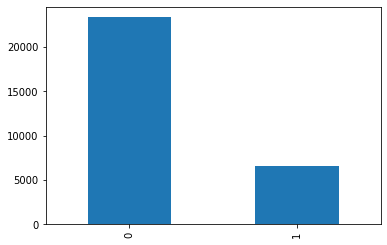

In [ ]:
pd.value_counts(y).plot(kind='bar')
plt.show()

In [ ]:
sm = SMOTE(random_state=42)
X_new, y_new = sm.fit_resample(X, y)

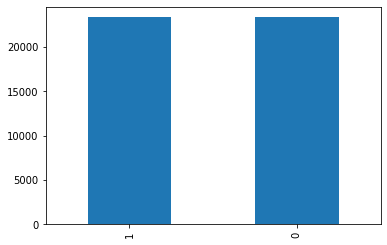

In [ ]:
pd.value_counts(y_new).plot(kind='bar')
plt.show()

### IV) Data split - Train , test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new,y_new,test_size=0.2, random_state=5)

### V) Scale the numerical columns by using min_max scaler for both X_train, X_test

In [ ]:
numerical_features

['LIMIT_BAL',
 'AGE',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'Number_of_paid_on_time',
 'Number_of_times_delayed',
 'most_recent_month_delayed',
 'Outstanding_total_amount']

In [ ]:
numerical_convert=[
    'LIMIT_BAL',
    'AGE',
    'Outstanding_total_amount']

In [ ]:

MM = MinMaxScaler()
X_train[numerical_convert]=MM.fit_transform(X_train[numerical_convert])
X_test[numerical_convert]=MM.transform(X_test[numerical_convert])

In [ ]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Number_of_paid_on_time,Number_of_times_delayed,most_recent_month_delayed,Outstanding_total_amount
7186,0.232323,2,1,1,0.241379,-1,-1,0,-1,0,...,10420,1150,5928,3619,13227,7764,6,0,0,0.394093
33581,0.021809,2,2,1,0.517241,2,2,2,2,2,...,1247,1584,111,1440,0,843,0,6,1,0.407127
17334,0.494949,2,1,1,0.275862,1,-1,-1,-1,-1,...,2529,2971,200,38144,0,8479,5,1,0,0.401111
8144,0.040404,1,1,2,0.034483,0,0,2,2,0,...,3600,1400,0,1200,2000,1000,4,2,3,0.408034
31646,0.020202,1,2,2,0.086207,6,5,4,3,2,...,0,7,0,0,985,1018,0,5,1,0.420846


In [ ]:
X_test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Number_of_paid_on_time,Number_of_times_delayed,most_recent_month_delayed,Outstanding_total_amount
12621,0.222222,2,3,1,0.155172,0,0,0,0,0,...,7214,6264,10000,5028,5000,5000,6,0,0,0.528706
37856,0.070579,1,2,1,0.275862,0,0,0,-2,-2,...,1010,0,0,0,0,0,6,0,0,0.400852
18436,0.070707,2,4,2,0.068966,0,0,0,0,0,...,1500,2000,1000,0,0,0,6,0,0,0.396866
295,0.191919,1,1,2,0.172414,0,0,0,0,0,...,9000,7465,4715,4804,5141,5300,6,0,0,0.532449
9443,0.141414,1,1,2,0.172414,-1,-1,-1,-1,0,...,0,601,4102,0,2019,5515,6,0,0,0.394438


## D) Feature Engineering

### I) Find out the optimal number of features to select

In [ ]:
# folds = KFold(n_splits=10,shuffle=True, random_state=100)


In [ ]:
model = xgb.XGBClassifier()


In [ ]:
hyper_params=[{'n_features_to_select':[3,5,10,15,20,24]}]

In [ ]:
rfe=RFE(model)

In [ ]:
modelcv=GridSearchCV(estimator=rfe,param_grid = hyper_params, scoring='accuracy', verbose=1, return_train_score=True)

In [ ]:
modelcv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RFE(estimator=XGBClassifier()),
             param_grid=[{'n_features_to_select': [3, 5, 10, 15, 20, 24]}],
             return_train_score=True, scoring='accuracy', verbose=1)

In [ ]:
cvresults=pd.DataFrame(modelcv.cv_results_)
cvresults

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,38.035723,0.987270,0.020107,0.000692,3,{'n_features_to_select': 3},0.791360,0.781998,0.795345,0.780498,...,0.789498,0.007102,6,0.789032,0.791373,0.788036,0.791747,0.787300,0.789498,0.001775
1,36.240296,0.523728,0.023429,0.000790,5,{'n_features_to_select': 5},0.799117,0.788819,0.798020,0.788256,...,0.794607,0.004972,5,0.793513,0.797492,0.794991,0.798067,0.793653,0.795543,0.001906
2,32.538832,0.526257,0.022960,0.000660,10,{'n_features_to_select': 10},0.804735,0.800588,0.810728,0.806982,...,0.807528,0.004829,4,0.804481,0.809798,0.808801,0.813148,0.809002,0.809046,0.002767
3,26.927473,0.362638,0.023885,0.000326,15,{'n_features_to_select': 15},0.822790,0.814632,0.820225,0.811396,...,0.818201,0.004435,3,0.820599,0.819562,0.819568,0.819501,0.818097,0.819465,0.000797
4,18.786547,0.237630,0.024755,0.000402,20,{'n_features_to_select': 20},0.821319,0.817173,0.821562,0.812868,...,0.819111,0.003634,2,0.822137,0.824043,0.822310,0.824651,0.821073,0.822843,0.001313
5,10.320928,0.146184,0.024805,0.000252,24,{'n_features_to_select': 24},0.821854,0.819313,0.822766,0.813537,...,0.819887,0.003380,1,0.822538,0.824544,0.824550,0.825085,0.822444,0.823832,0.001113


In [ ]:
print(np.mean(cvresults))

mean_fit_time                 27.141633
std_fit_time                   0.463951
mean_score_time                0.023324
std_score_time                 0.000521
param_n_features_to_select    12.833333
split0_test_score              0.810196
split1_test_score              0.803754
split2_test_score              0.811441
split3_test_score              0.802256
split4_test_score              0.813046
mean_test_score                0.808139
std_test_score                 0.004725
rank_test_score                3.500000
split0_train_score             0.808716
split1_train_score             0.811135
split2_train_score             0.809709
split3_train_score             0.812033
split4_train_score             0.808595
mean_train_score               0.810038
std_train_score                0.001612
dtype: float64


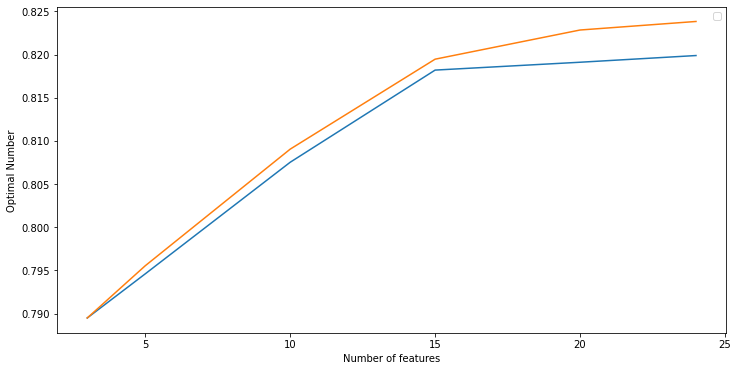

In [ ]:
plt.figure(figsize=(12,6))
x_ticks = [5, 10, 15, 20, 25]

plt.xticks(ticks=x_ticks)
plt.plot(cvresults['param_n_features_to_select'], cvresults['mean_test_score'])

#plotting the mean train cvresults
plt.plot(cvresults['param_n_features_to_select'], cvresults['mean_train_score'])

plt.xlabel('Number of features')
plt.ylabel('Optimal Number')
plt.legend()
plt.show()

In this study, the optimal number of features to be used to predicted is around 20.

In this case, we can select 15 features for the model.

#### Feature Importance

<Figure size 1440x432 with 0 Axes>

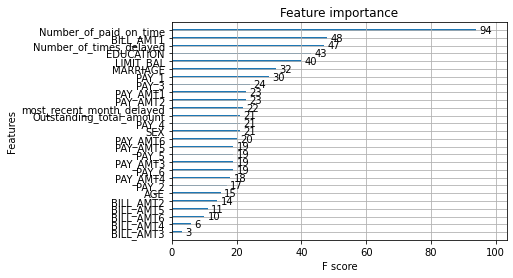

In [ ]:
# plot feature importance
plt.figure(figsize = (20, 6))
model.fit(X_new, y_new)
plot_importance(model)
plt.show()

In [ ]:
importance_table=pd.DataFrame([X_new.columns,model.feature_importances_]).T
importance_table.columns=['features','importance']
importance_table.sort_values(by='importance',ascending=False)

,features,importance
23,Number_of_paid_on_time,0.32104
24,Number_of_times_delayed,0.088865
1,SEX,0.064792
3,MARRIAGE,0.054252
25,most_recent_month_delayed,0.036987
8,PAY_4,0.034049
10,PAY_6,0.033041
7,PAY_3,0.032875
5,PAY_1,0.027817
9,PAY_5,0.026766


In [ ]:
data.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'Number_of_paid_on_time',
       'Number_of_times_delayed', 'most_recent_month_delayed',
       'Outstanding_total_amount'],
      dtype='object')

In [ ]:
selected_features=[
    'LIMIT_BAL', 
    'SEX', 
    'EDUCATION',
    'MARRIAGE',
    'AGE', 
    'PAY_1', 
    'PAY_2',
    'PAY_3', 
    'PAY_4', 
    'PAY_5', 
    'PAY_6', 
    'Number_of_paid_on_time',
    'Number_of_times_delayed', 
    'most_recent_month_delayed',
    'Outstanding_total_amount'
    ]

In [ ]:
X_train=X_train[selected_features]
X_test = X_test[selected_features]

## E) Model Selection 

### I) Use GridSearch to find the best performance models

There are a few classifiers widely used for classification problem. Below is the performance result in accuracy 


1) XGBoost

2) Random Forest Classifier

3) Logistic Regression

4) KN Neighbors

5) Neural Network

In [ ]:
def test(models, X_train, y_train, X_test, y_test, iterations = 100):
    accuracy_results = {}
    for i in models:
        accuracy_train = []
        accuracy_test = []
        for j in range(iterations):

            accuracy_test.append(accuracy_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            accuracy_train.append(accuracy_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
            
        accuracy_results[i] = [np.mean(accuracy_train), np.mean(accuracy_test)]
    return pd.DataFrame(accuracy_results)

In [ ]:
xgb_params = {
    'model__n_estimators': [5,15,10,20,30,40,50,100],
    'model__max_depth': [3, 6, 9,15,25],
    'model__learning_rate': [0.01,0.05, 0.1, 0.20]}

rf_params = {
    'max_depth': [2, 3, 5, 6, 10, 20, 50],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"],
    'class_weight': ['balanced']
}
logistic_params = {
    'C': np.logspace(-5, 8, 15),
    'class_weight': ['balanced']
}

knn_params = {
    'n_neighbors': [3, 5, 10, 15, 50, 100, 150, 200, 1000]
}

In [ ]:
models2 = {
    'xgb': GridSearchCV(xgb.XGBClassifier(),
                             param_grid=xgb_params).fit(X_train, y_train).best_estimator_,
    'RandomF': GridSearchCV(RandomForestClassifier(), 
                               param_grid=rf_params).fit(X_train, y_train).best_estimator_,
    'logistic': GridSearchCV(LogisticRegression(), 
                               param_grid=logistic_params).fit(X_train, y_train).best_estimator_,
    'knn': GridSearchCV(KNeighborsClassifier(),
                             param_grid=knn_params).fit(X_train, y_train).best_estimator_,}

In [ ]:
test(models2, X_train, y_train, X_test, y_test)

In [ ]:
models2

#### Neural Network - DNN

In [ ]:
attribute_len=len(X_train.columns)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(100, input_shape=(attribute_len,), activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dropout(rate=0.2),
      keras.layers.Dense(20, activation='relu'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1, activation='sigmoid')

])

optimizer = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred_prob=[np.around(item,decimals = 2) for item in y_pred_prob]

In [ ]:
y_pred=[]

for element in y_pred_prob:
    if element >= 0 and element <0.5:
        y_pred.append(0)
    elif element >=0.5 and element <=1:
        y_pred.append(1)

    

In [ ]:
print(classification_report(y_test, y_pred))

### Among all these models, Random Forest performs the best

In [ ]:
y_pred=models2['RandomF'].predict(X_test)

## F) Evaluation for the best model performance 

In [ ]:
models2['RandomF']

In [ ]:
plot_roc_curve(models2['RandomF'], X_test, y_test)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=models2['RandomF'].classes_)
disp.plot()
plt.show()

In [ ]:
feature_importance_df = pd.DataFrame({'Feature_name': X_train.columns, 'Importance': models2['RandomF'].feature_importances_})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (20, 6))
plt.title('Features importance', fontsize=15)
ax = plt.bar(feature_importance_df['Feature_name'][:10], feature_importance_df['Importance'][:10])
plt.xticks(rotation=90)
plt.show()   

## G) How the predictions can be used in Credit Sesame's product


Since credit sesame is a company that makes consumer credit and loan management simple and automated. The objective of the company is to help the individual manage their credit score, compare the loan providers's rates and find the best strategy to get a loan approved. 

In order to get a loan, the individual often requires to submit the loan application first blindfoldedly. However, if the application gets declined, the credit score would go down significantly which might also affect the individual to apply with the other loan providers which implies the individual might want to know the likelihood of this loan approved before submitting the applicant. 

This model can predict the probability or the likelihood that the individual will get defaulted in credit card's payment and the model can also be used to predict the likelihood of the loan approved based on the attributes of the applicant / individual. 